
# What is the most popular project on DataCamp?

This notebook shows you how to discover the popularity of projects on DataCamp. 

First, we will scrape the data from the website. Then, we load this data into a Pandas DataFrame. In the end, we can find out the most popular project on DataCamp (by technology)!



## 1. Get overview page into BeautifulSoup object

As the amount of participants is only available on the individual project pages, we will first have to scrape all the individual URLs from the overview page. To do this, we will use the Python libraries [requests](http://docs.python-requests.org/en/master/user/quickstart/#make-a-request) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/).


In [1]:
# Import libraries BeautifulSoup & requests
import bs4 
import requests

# URL of the overview page which contains all the links to the individual projects 
overview_url = "https://www.datacamp.com/projects"

# Get URL response with the requests library
r = requests.get(overview_url)

# Read content of response
html = r.text

# Create BeautifulSoup object of content to be able to parse HTML page
soup = bs4.BeautifulSoup(html, "lxml")

# Print out object type
type(soup)


bs4.BeautifulSoup


## 2. Get info on individual projects

By looking at the "Page Source" (right mouse click menu or shortcut "CTRL+U") of the overview page, you will see that the HTMLs of all the individual projects look like the code in the cell below. Using BeautifulSoup, we will extract relevant info from the HTML elements, like the URL to the individual project, the type of technology and so on.


In [2]:
# List of all 'div' elements with class 'dc-project-block-wrapper'
divs = soup.findAll("div", {"class": "dc-project-block-wrapper"})

# Create empty list for all info of elements
project_info_list = []

# Loop over 'div' elements and extract info by element
for div in divs:
    
    # Upcoming projects don't have statistics, so skip if upcoming
    # <p class="dc-project-block__description-placeholder"></p>
    if div.findAll("p",{"class": "dc-project-block__description-placeholder"}):
        continue
 
    # Create empty dictionary for info by element
    project_info = {}

    ## Get URL to project & add to dictionary
    # = 'href' attribute of first 'a' element
    # <a class="shim" href="/projects/374"></a>
    url = div.find_next("a").get("href").strip()
    project_info["url"] = "https://www.datacamp.com" + url
    
    ## Get technology of project & add to dictionary
    # = first part of text of 'alt' attribute of 'img' element with class 'dc-project-block__technology'
    # <img class="dc-project-block__technology" src="..." alt="Python icon" />
    tech_text = div.find_next("img", {"class":"dc-project-block__technology"}).get("alt")
    tech = tech_text.split()[0]
    project_info["tech"] = tech
    
    ## Get title of project & add to dictionary
    # = text of 'h5' element with class 'dc-project-block__title'
    # <h5 class="dc-project-block__title">Naïve Bees: Image Loading and Processing</h5>
    title = div.find_next("h5", {"class":"dc-project-block__title"}).text.strip()
    project_info["title"] = title
    
    ## Get description of project & add to dictionary
    # = text of 'small' element with class 'dc-project-block__description'
    # <small class="dc-project-block__description">Load, transform, and .. in Python.</small>
    description = div.find_next("small", {"class": "dc-project-block__description"}).text.strip()
    project_info["description"] = description
    
    ## Get author of project & add to dictionary
    # = text of p element with class 'dc-project-block__author-name'
    # <p class="dc-project-block__author-name">Peter Bull</p>
    author = div.find_next("p", {"class": "dc-project-block__author-name"}).text.strip()
    project_info["author"] = author
    
    # Add dictionary to list
    project_info_list.append(project_info)
    
    
# Inspect info
print("Number of DataCamp projects : {}".format(len(project_info_list)))
project_info_list[:2]


Number of DataCamp projects : 65


[{'author': 'Rasmus Bååth',
  'description': "If you've never done a DataCamp project, this is the place to start!",
  'tech': 'Python',
  'title': 'Introduction to DataCamp Projects',
  'url': 'https://www.datacamp.com/projects/33'},
 {'author': 'Rasmus Bååth',
  'description': "If you've never done a DataCamp project, this is the place to start!",
  'tech': 'R',
  'title': 'Introduction to DataCamp Projects',
  'url': 'https://www.datacamp.com/projects/41'}]


## 3. Get statistics of individual projects

Information like number of participants and points is only available on the individual project pages and thus will be extracted from there in a likewise manner as above. An example of the HTML page source we are interested in is shown in the cell below.


In [3]:
# ! Because of the 50+ projects, this cell might run for a minutes or two

# Loop over all projects 
for i,project in enumerate(project_info_list):
    
    # Create BeautifulSoup object of HTML of project page
    html_project = requests.get(project_info_list[i]["url"]).text
    soup_project = bs4.BeautifulSoup(html_project, "lxml")
    
    # Get 'ul' element
    ul = soup_project.find("ul", {"class": "header-hero__stats"})
    
    # Get tasks & add to dictionary
    tasks = ul.find_next("li", {"class": "header-hero__stat header-hero__stat--exercises"}).text.strip()
    project_info_list[i]["tasks"] = tasks
    
    # Get participants & add to dictionary
    participants = ul.find_next("li", {"class": "header-hero__stat header-hero__stat--participants"}).text.strip()
    project_info_list[i]["participants"] = participants
    
    # Get points & add to dictionary
    points = ul.find_next("li", {"class": "header-hero__stat header-hero__stat--xp"}).text.strip()
    project_info_list[i]["points"] = points
    

# Inspect info
project_info_list[:1]


[{'author': 'Rasmus Bååth',
  'description': "If you've never done a DataCamp project, this is the place to start!",
  'participants': '70,038 participants',
  'points': '1,500 XP',
  'tasks': '6 tasks',
  'tech': 'Python',
  'title': 'Introduction to DataCamp Projects',
  'url': 'https://www.datacamp.com/projects/33'}]


## 4. Create Pandas DataFrame

We will create a Pandas DataFrame of the scraped data. As all scraped data is stored as text, we will also do some data cleaning. We will transform the relevant columns (tasks, participants & points) into numerical values, so we are able to aggregate this data. After this last step, we will be able to find the most popular project on DataCamp by technology!


In [4]:
# Import Pandas library
import pandas as pd

# Create DataFrame from list of dictionaries
df_projects = pd.DataFrame(project_info_list) # Yes, it is that easy!

# Inspect DataFrame
df_projects.info() # notice how all columns have data type 'object' (=text)
df_projects.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 8 columns):
author          65 non-null object
description     65 non-null object
participants    65 non-null object
points          65 non-null object
tasks           65 non-null object
tech            65 non-null object
title           65 non-null object
url             65 non-null object
dtypes: object(8)
memory usage: 4.1+ KB


,author,description,participants,points,tasks,tech,title,url
0,Rasmus Bååth,"If you've never done a DataCamp project, this ...","70,038 participants","1,500 XP",6 tasks,Python,Introduction to DataCamp Projects,https://www.datacamp.com/projects/33
1,Rasmus Bååth,"If you've never done a DataCamp project, this ...","36,260 participants","1,500 XP",6 tasks,R,Introduction to DataCamp Projects,https://www.datacamp.com/projects/41
2,Ramnath Vaidyanathan,In this project we will explore a database of ...,"22,774 participants","1,500 XP",7 tasks,Python,Exploring 67 years of LEGO,https://www.datacamp.com/projects/10
3,Rasmus Bååth,Reanalyse the data behind one of the most impo...,"14,224 participants","1,500 XP",9 tasks,Python,Dr. Semmelweis and the Discovery of Handwashing,https://www.datacamp.com/projects/20
4,Antonio Sánchez Chinchón,Use R to make art and create imaginary flowers...,"10,615 participants","1,500 XP",9 tasks,R,Phyllotaxis: Draw flowers using mathematics,https://www.datacamp.com/projects/62


In [5]:
# Create function to extract the numerical value from text
def GetNumericalValue(text):
    
    """
    Notice how the numerical value is always the first group of characters:
    '62 Exercises', '4 hours', '1,171,673 Participants', '6,200 XP', 0 Videos'

    Example of transformation:
    
    text = "6,200 XP"
    text.split() = ["6,200", "XP"]  # split() by default on spaces
    text.split()[0] = "6,200"  # first element
    text.split()[0].replace (',','') = "6200"  # remove comma, still data type str
    int(text.split()[0].replace(',','')) = 6200  # data type int
    """
    
    # Split text, take first block of characters, remove comma's & change data type to integer
    return int(text.split()[0].replace(',',''))


# Transform columns with numerical values
df_projects["tasks"] = df_projects["tasks"].apply(lambda x : GetNumericalValue(x))
df_projects["participants"] = df_projects["participants"].apply(lambda x : GetNumericalValue(x))
df_projects["points"] = df_projects["points"].apply(lambda x : GetNumericalValue(x))
    
# Inspect DataFrame (after transformations)
df_projects.info() # notice how the above columns changed to data type 'int64' (=integer)
df_projects.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 8 columns):
author          65 non-null object
description     65 non-null object
participants    65 non-null int64
points          65 non-null int64
tasks           65 non-null int64
tech            65 non-null object
title           65 non-null object
url             65 non-null object
dtypes: int64(3), object(5)
memory usage: 4.1+ KB


,author,description,participants,points,tasks,tech,title,url
0,Rasmus Bååth,"If you've never done a DataCamp project, this ...",70038,1500,6,Python,Introduction to DataCamp Projects,https://www.datacamp.com/projects/33
1,Rasmus Bååth,"If you've never done a DataCamp project, this ...",36260,1500,6,R,Introduction to DataCamp Projects,https://www.datacamp.com/projects/41
2,Ramnath Vaidyanathan,In this project we will explore a database of ...,22774,1500,7,Python,Exploring 67 years of LEGO,https://www.datacamp.com/projects/10
3,Rasmus Bååth,Reanalyse the data behind one of the most impo...,14224,1500,9,Python,Dr. Semmelweis and the Discovery of Handwashing,https://www.datacamp.com/projects/20
4,Antonio Sánchez Chinchón,Use R to make art and create imaginary flowers...,10615,1500,9,R,Phyllotaxis: Draw flowers using mathematics,https://www.datacamp.com/projects/62



## 5. Find out what the most popular project / technology / author / ... is on DataCamp!

We can use the clean DataFrame to find out what we want about DataCamp projects. The cells below will show you some interesting facts. What else would you like to know about this? Have fun playing around!


In [6]:
# Create DataFrame for outputting results
df_results = df_projects[["title","tech","participants","author","points","tasks"]]

# The most popular projects on DataCamp
df_results.sort_values("participants", ascending=False).head(10)

# As of March 2019, the 'Introduction to DataCamp Projects' in Python is the most popular project on DataCamp!


,title,tech,participants,author,points,tasks
0,Introduction to DataCamp Projects,Python,70038,Rasmus Bååth,1500,6
1,Introduction to DataCamp Projects,R,36260,Rasmus Bååth,1500,6
2,Exploring 67 years of LEGO,Python,22774,Ramnath Vaidyanathan,1500,7
3,Dr. Semmelweis and the Discovery of Handwashing,Python,14224,Rasmus Bååth,1500,9
4,Phyllotaxis: Draw flowers using mathematics,R,10615,Antonio Sánchez Chinchón,1500,9
5,Exploring the Bitcoin Cryptocurrency Market,Python,6825,Juan González-Vallinas,1500,10
6,Dr. Semmelweis and the Discovery of Handwashing,R,6458,Rasmus Bååth,1500,9
7,A Network analysis of Game of Thrones,Python,4638,Mridul Seth,1500,9
8,Risk and Returns: The Sharpe Ratio,Python,3081,Stefan Jansen,1500,11
9,Exploring the Kaggle Data Science Survey,R,3056,Amber Thomas,1500,9


In [7]:
# The most popular technology on DataCamp by participants
df_results.groupby("tech").sum().sort_values("participants", ascending=False)

# Python projects have by far the most participants!


,participants,points,tasks
tech,,,
Python,148393,46500,299
R,73851,49500,333
Sql,2523,1500,8


In [8]:
# The most popular author on DataCamp by participants
df_results.groupby("author").sum().sort_values("participants", ascending=False).head()

# No surprise by looking at the most popular projects, Rasmus Bååth is the most popular project author on DataCamp!


,participants,points,tasks
author,,,
Rasmus Bååth,135198,15000,91
Ramnath Vaidyanathan,22774,1500,7
Antonio Sánchez Chinchón,11809,3000,19
Juan González-Vallinas,6825,1500,10
David Venturi,5374,6000,38


In [9]:
# The most popular technology on DataCamp by number of projects
df_results[["tech","title"]].groupby("tech").count().sort_values("title", ascending=False)

# Surprisingly, the amount of R projects on DataCamp is higher than of Python projects!


,title
tech,
R,33
Python,31
Sql,1


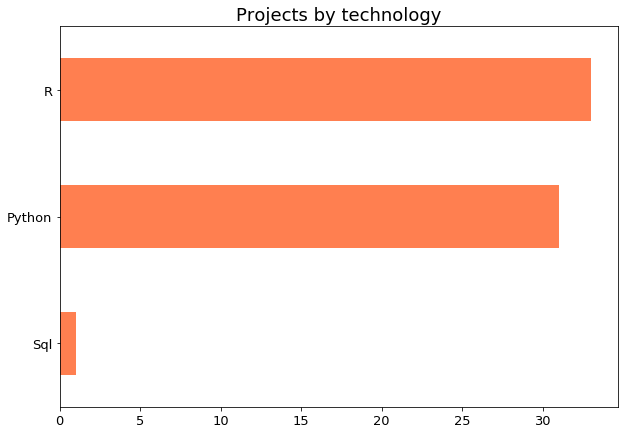

In [10]:
# Visualize number of projects by technology with Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Horizontal bar chart
ax = df_results["tech"].value_counts().plot(kind="barh", figsize=(10,7), color="coral", fontsize=13)
ax.set_title("Projects by technology", fontsize=18)
ax.invert_yaxis() # highest on top


        title  participants   avg
tech                             
Python     31        148393  4786
Sql         1          2523  2523
R          33         73851  2237


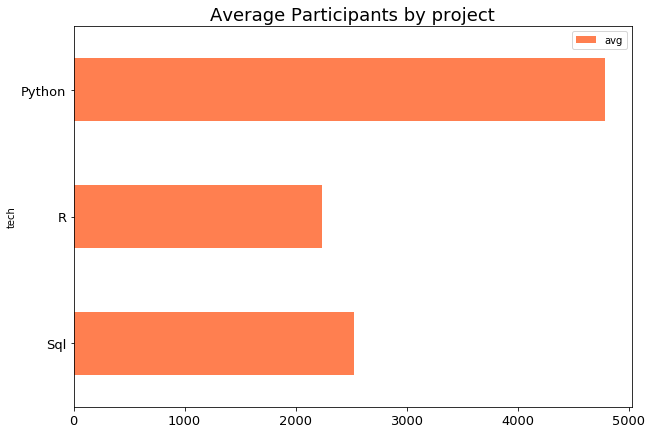

In [11]:
# Get the average amount of participants by project

# Get amount of participants by technology
df_participants = df_results[["tech","participants"]].groupby("tech").sum()

# Get amount of projects by technology
df_counts = df_results[["tech","title"]].groupby("tech").count()

# Join DataFrames
df_join = df_counts.join(df_participants)
df_join["avg"] = (df_join["participants"] / df_join["title"]).astype(int)

# Show table
print(df_join.sort_values("avg", ascending=False))

# Show barchart
rx = df_join[["avg"]].plot(kind="barh", figsize=(10,7), color="coral", fontsize=13)
rx.set_title("Average Participants by project", fontsize=18)
rx.invert_yaxis() # highest on top

# Based on average participants by project, Python projects are by far the most popular technology!
